In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import np_utils
import pandas as pd
from scipy import signal
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('expand_frame_repr', False)

In [ ]:
arr = np.random.randint(low=0,high=10,size=(5,4,3))
arr2 = np.reshape(arr,newshape=(3,5,4))
print(arr,end='\n')
print(arr2)
print(np.array_equal(arr[...,0],arr2[0]))
print(np.allclose(arr[..., 0], arr2[0]))

[[[2 6 2]
  [2 1 6]
  [0 1 4]
  [4 7 3]]

 [[6 9 2]
  [8 5 6]
  [5 4 9]
  [3 0 1]]

 [[8 6 0]
  [6 3 2]
  [8 5 2]
  [6 8 4]]

 [[0 2 3]
  [6 2 2]
  [7 4 0]
  [4 1 3]]

 [[0 5 6]
  [8 6 1]
  [0 0 3]
  [9 5 2]]]
[[[2 6 2 2]
  [1 6 0 1]
  [4 4 7 3]
  [6 9 2 8]
  [5 6 5 4]]

 [[9 3 0 1]
  [8 6 0 6]
  [3 2 8 5]
  [2 6 8 4]
  [0 2 3 6]]

 [[2 2 7 4]
  [0 4 1 3]
  [0 5 6 8]
  [6 1 0 0]
  [3 9 5 2]]]
False
False


# Layer (Parent Class)

In [ ]:
# Base class
class Layer:
  def __init__(self):
      self.input = None
      self.output = None
      self.is_initialized = False

  # computes the output Y of a layer for a given input X
  def forward_propagation(self, input):
      raise NotImplementedError

  # computes dE/dX for a given dE/dY (and update parameters if any)
  def backward_propagation(self, output_error, learning_rate):
      raise NotImplementedError

# Dense Layer

In [ ]:
class FCLayer(Layer):
  def __init__(self,output_dim):
    super(FCLayer,self).__init__()
    self.output_dim=output_dim

  def initialize_parameters(self,input_dim):
    self.is_initialized=True
    self.input_dim=input_dim
    self.weights = np.random.randn(input_dim,self.output_dim) / np.sqrt(input_dim + self.output_dim)
    self.bias = np.random.randn(1,self.output_dim) / np.sqrt(input_dim + self.output_dim)


  def forward_propagation(self, input):
    self.input=input
    if not self.is_initialized:
      self.initialize_parameters(input.shape[-1])
    self.output = input @ self.weights + self.bias
    return self.output

  def backward_propagation(self, output_error, learning_rate):
    dW = self.input.T @ output_error
    db = output_error
    dX = output_error @ self.weights.T
    # update parameters
    self.weights -= learning_rate*dW
    self.bias -= learning_rate*db
    return dX


# Activation Layer

In [ ]:
class ActivationLayer(Layer):
  def __init__(self,activation,activation_prime):
    super(ActivationLayer,self).__init__()
    self.activation = activation
    self.activation_prime = activation_prime

  def forward_propagation(self, input):
    self.input=input
    self.output = self.activation(input)
    return self.output

  def backward_propagation(self, output_error, learning_rate):
    return output_error * self.activation_prime(self.input)

# Activation Functions

## Tanh

In [ ]:
def tanh(x):
  return np.tanh(x);

def tanh_prime(x):
  return 1-np.tanh(x)**2;

## Relu

In [ ]:
def relu(x):
  return np.maximum(0,x)

def relu_prime(x):
  x[x<=0] = 0
  x[x>0] = 1
  return x

## Sigmoid

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
  s = sigmoid(x)
  return s * (1 - s)

## Softmax

In [ ]:
class SoftmaxLayer(Layer):

  def forward_propagation(self,input):
    self.input=input
    tmp = np.exp(input)
    self.output = tmp/np.sum(tmp)
    return self.output

  def backward_propagation(self, output_error, learning_rate):
    n = self.output.size
    dX = self.output*(np.identity(n)-self.output.T)
    dX = output_error @ dX

    return dX

# Flatten Layer

In [ ]:
class FlattenLayer(Layer):
  def __init__(self):
    super(FlattenLayer,self).__init__()
  def forward_propagation(self, input):
    self.input=input
    self.output = input.flatten().reshape(1,-1)
    return self.output

  def backward_propagation(self, dY, learning_rate):
    return dY.reshape(self.input.shape)

# Dropout Layer

In [ ]:
class DropoutLayer(Layer):
  def __init__(self,drop_rate=0.2):
    self.drop_rate = drop_rate

  def forward_propagation(self, input):
    self.input = input
    self.dropout = np.random.randn(*input.shape)>self.drop_rate
    self.output = np.copy(self.input)
    self.output *= self.dropout
    self.output /= (1-self.drop_rate)
    return self.output

  def backward_propagation(self, output_error, learning_rate):
    dX = output_error*self.dropout
    dX /= (1-self.drop_rate)
    return dX

# Convolutional Layer

Lets try out to construct the cross correlation method from scratch.
Note: no need to implement convolve from scratch as it is just full cross correlation but the kernels need to rotate 180 degrees

In [ ]:
def cross_correlation(input,kernel,padding='valid'):
  x=input
  kernel_size = kernel.shape[0]
  new_height = x.shape[0]-kernel_size+1
  new_width = x.shape[1]-kernel_size+1
  if padding=='full':
    x = np.zeros(shape=(input.shape[0]+2*(kernel_size-1),input.shape[1]+2*(kernel_size-1)))
    x = fill_array(x,input)
    # print(x)
    new_height = x.shape[0]-kernel_size+1
    new_width = x.shape[1]-kernel_size+1
  elif padding=='same':
    p = kernel_size-1
    x = np.zeros(shape=(input.shape[0]+p,input.shape[1]+p))
    start = p//2
    end = -p//2 if p>0 else x.shape[0]
    x[start:end,start:end] = input
    new_height,new_width=input.shape

  output = np.zeros(shape=(new_height,new_width))
  for i in range(new_height):
    for j in range(new_width):
      mat = x[i:i+kernel_size,j:j+kernel_size]
      output[i,j] = np.sum(mat*kernel)
  return output

def fill_array(x,y):
  start_x = int(np.ceil((x.shape[0]-y.shape[0])/2))
  start_y = int(np.ceil((x.shape[1]-y.shape[1])/2))
  x[start_x:start_x+y.shape[0],start_y:start_y+y.shape[1]]=y
  return x

In [ ]:
class Conv2D(Layer):
  def __init__(self,kernel_size,filters):
    super(Conv2D,self).__init__()
    self.kernel_size = kernel_size
    self.filters = filters

  def initialize_parameters(self,input_shape):
    self.is_initialized = True
    self.input_shape=input_shape
    input_depth,input_height,input_width = input_shape
    self.input_depth = input_depth
    self.output_shape = (self.filters,input_height-self.kernel_size+1,input_width-self.kernel_size+1)
    self.kernels_shape = (self.filters,self.input_depth,self.kernel_size,self.kernel_size)
    self.kernels = np.random.randn(*self.kernels_shape)
    self.bias = np.random.randn(*self.output_shape)
    self.kernels_shape_for_summary = (self.filters,self.kernel_size,self.kernel_size,self.input_depth)
    # self.input_shape_for_summary = (input_height,input_width,input_depth)
    # self.output_shape_for_summary = (self.output_shape[1],self.output_shape[2],self.output_shape[0])

  def forward_propagation(self, input):
    self.input=input
    self.input_conv = np.reshape(input,newshape=(input.shape[-1],input.shape[0],input.shape[1]))
    if not self.is_initialized:
      self.initialize_parameters(self.input_conv.shape)
    self.output_conv = np.copy(self.bias)
    for i in range(self.filters):
      for j in range(self.input_depth):
        # you can use cross_correlation method implemented above instead of signal.correlate2d, however it is a little bit slower
        self.output_conv[i] += signal.correlate2d(self.input_conv[j],self.kernels[i,j],'valid')
    self.output = np.reshape(self.output_conv,newshape=(self.output_conv.shape[1],self.output_conv.shape[2],self.output_conv.shape[0]))
    return self.output

  def backward_propagation(self, output_error, learning_rate):
    output_error = np.reshape(output_error,newshape=self.output_shape)
    db = output_error
    dK = np.zeros(shape=self.kernels_shape)
    dX = np.zeros(shape=self.input_shape)
    for i in range(self.filters):
      for j in range(self.input_depth):
        # you can use cross_correlation method implemented above instead of signal.correlate2d, however it is a little bit slower
        dK[i,j] += signal.correlate2d(self.input_conv[j],output_error[i],'valid')
        dX[j] += signal.convolve2d(output_error[i],self.kernels[i,j],'full')
    self.kernels -= learning_rate*dK
    self.bias -= learning_rate*db
    dX = np.reshape(dX,newshape=self.input.shape)
    return dX


In [ ]:
arr1 = np.array([[1,2,3],[4,5,6],[7,8,9]])
arr2 = np.array([[1,2,3],[4,5,6],[7,8,9]])
arr3 = np.array([[1,2],[4,5]])
arr4 = np.random.randint(low=0,high=40,size=(8,8))
arr5 = np.random.randint(low=0,high=20,size=(7,7))
ans_1 = cross_correlation(arr4,arr5,'same')
ans_2 = signal.correlate2d(arr4,arr5,'same')
# print(arr1)
# print(arr2)
print(ans_1)
print(ans_2)
print(np.equal(ans_1,ans_2))

[[2139. 4057. 3538. 4656. 4362. 4715. 3935. 2528.]
 [3259. 5103. 5409. 5960. 6343. 6058. 5543. 3462.]
 [4251. 5591. 6450. 7285. 7331. 6769. 6302. 4134.]
 [4992. 5763. 8079. 8009. 8436. 7767. 7186. 5427.]
 [4784. 5732. 7327. 8003. 9048. 8602. 7105. 5799.]
 [4432. 5105. 6920. 7802. 8418. 6702. 7049. 5183.]
 [3451. 4339. 5244. 6513. 6276. 5007. 5531. 2715.]
 [2936. 3114. 4758. 5184. 4704. 3905. 4423. 2593.]]
[[2139 4057 3538 4656 4362 4715 3935 2528]
 [3259 5103 5409 5960 6343 6058 5543 3462]
 [4251 5591 6450 7285 7331 6769 6302 4134]
 [4992 5763 8079 8009 8436 7767 7186 5427]
 [4784 5732 7327 8003 9048 8602 7105 5799]
 [4432 5105 6920 7802 8418 6702 7049 5183]
 [3451 4339 5244 6513 6276 5007 5531 2715]
 [2936 3114 4758 5184 4704 3905 4423 2593]]
[[ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  Tru

In [ ]:
def tryout(ker,inp):
  ker_2 = np.reshape(ker,newshape=(ker.shape[0],ker.shape[-1],ker.shape[1],ker.shape[2]))
  depth = ker.shape[0]
  input_depth = inp.shape[-1]
  inp_2 = np.reshape(inp,newshape=(inp.shape[-1],inp.shape[0],inp.shape[1]))
  output = np.zeros(shape=(depth,inp.shape[0]-ker.shape[1]+1,inp.shape[1]-ker.shape[2]+1))
  for i in range(depth):
    for j in range(input_depth):
      output[i] += signal.correlate2d(inp_2[j],ker_2[i,j],'valid')
  output = np.reshape(output,newshape=(output.shape[1],output.shape[2],output.shape[0]))
  return output

this used to be the old code and the model did learn with it and no errors were encountered however the output of this code was not consistent with the output of the tryout2 function


In [ ]:
# def tryout(ker,inp):
#   depth = ker.shape[0]
#   input_depth = inp.shape[-1]
#   output = np.zeros(shape=(inp.shape[0]-ker.shape[1]+1,inp.shape[1]-ker.shape[2]+1,depth))
#   for i in range(depth):
#     for j in range(input_depth):
#       # k = ker[i,...,j]
#       # iii = inp[...,j]
#       # print(f'curr_inp={iii}, ker={k}')
#       output[...,i] += signal.correlate2d(inp[...,j],ker[i,:,:,j],'valid')
#   return output

In [ ]:
def tryout2(kernels,input):
  depth = kernels.shape[0]
  input_depth = input.shape[0]
  output = np.zeros(shape=(depth,input.shape[1]-kernels.shape[2]+1,input.shape[2]-kernels.shape[3]+1))
  for i in range(depth):
      for j in range(input_depth):
          output[i] += signal.correlate2d(input[j], kernels[i, j], "valid")
  return output

In [ ]:
arr1 = np.random.randint(low=0,high=50,size=(4,4,3))
arr2 = np.random.randint(low=0,high=5,size=(2,2,2,3))
arr1_2 = np.reshape(arr1,newshape=(arr1.shape[-1],arr1.shape[0],arr1.shape[1]))
arr2_2 = np.reshape(arr2,newshape=(arr2.shape[0],arr2.shape[-1],arr2.shape[1],arr2.shape[2]))
ans_1 = tryout(arr2,arr1)
ans_2 = tryout2(arr2_2,arr1_2)
ans_1_2 = np.reshape(ans_1,newshape=(ans_1.shape[-1],ans_1.shape[0],ans_1.shape[1]))

# print(np.correlate(arr1,arr2,'valid'))
print(f'arr1={arr1.shape}')
print(f'arr1_2={arr1_2.shape}')
print(f'arr2={arr2.shape}')
print(f'arr2_2={arr2_2.shape}')
print(f'ans_mine={ans_1_2}')
print(f'ans={ans_2}')

arr1=(4, 4, 3)
arr1_2=(3, 4, 4)
arr2=(2, 2, 2, 3)
arr2_2=(2, 3, 2, 2)
ans_mine=[[[480. 677. 694.]
  [490. 567. 565.]
  [562. 461. 421.]]

 [[451. 627. 465.]
  [575. 743. 564.]
  [696. 481. 588.]]]
ans=[[[480. 677. 694.]
  [490. 567. 565.]
  [562. 461. 421.]]

 [[451. 627. 465.]
  [575. 743. 564.]
  [696. 481. 588.]]]


# Pooling Layer

In [ ]:
def apply_pools(input,pool_size,strides,mode):
  x = np.arange(start=0, stop=input.shape[0],step=strides)
  y = np.arange(start=0, stop=input.shape[1],step=strides)
  mask = []
  height = ((input.shape[0]-pool_size)//strides) + 1
  width = ((input.shape[1]-pool_size)//strides) + 1
  output = np.zeros(shape=(height,width))
  z = 0
  for i in x:
    k = 0
    for j in y:
      mat = input[i:i+pool_size,j:j+pool_size]
      if mat.shape==(pool_size,pool_size):
        val = 0
        if mode=='max':
          val = np.max(mat)
          index = np.array(mat).argmax()
          a,b = np.unravel_index(index,mat.shape)
          mask.append((i+a,j+b))
        else:
          val = np.average(mat)
          mask.append((i,j))
        output[z,k] = val
      k+=1
    z+=1
  return output,mask


In [ ]:
arr1 = np.random.randint(low=0,high=20,size=(5,5))
print(arr1)
output,mask=apply_pools(arr1,2,2,'max')
print(output)
print(mask)

[[ 8 17 16 18 16]
 [ 0  8  6  0 12]
 [ 3  6 13  1  0]
 [11  4  6  7 15]
 [ 5 15  7 18 14]]
[[17. 18.]
 [11. 13.]]
[(0, 1), (0, 3), (3, 0), (2, 2)]


In [ ]:
class PoolingLayer(Layer):
  def __init__(self,pool_size,strides,mode):
    super(PoolingLayer,self).__init__()
    self.pool_size = pool_size
    self.strides = strides
    self.mode = mode

  def forward_propagation(self, input):
    self.input = input
    self.input_pool = np.reshape(input,newshape=(input.shape[-1],input.shape[0],input.shape[1]))
    self.masks = dict()
    height = ((input.shape[0]-self.pool_size)//self.strides) + 1
    width = ((input.shape[1]-self.pool_size)//self.strides) + 1
    output = np.zeros(shape=(input.shape[-1],height,width))
    for i in range(self.input_pool.shape[0]):
      output_pool,mask=apply_pools(self.input_pool[i],self.pool_size,self.strides,self.mode)
      self.masks[i] = mask
      output[i] = output_pool
    self.output_pool = output
    self.output = np.reshape(output,newshape=(height,width,output.shape[0]))
    return self.output

  def backward_propagation(self, output_error, learning_rate):
    output_error = np.reshape(output_error,newshape=self.output_pool.shape)
    dX = np.zeros(shape=self.input_pool.shape)
    for i in range(self.input_pool.shape[0]):
      z=0
      k=0
      arr = self.masks[i]
      for x,y in arr:
        if k==output_error.shape[-1]:
          k=0
          z+=1
        if self.mode=='max':
          dX[i,x,y] += output_error[i,z,k]
        else:
          denominator = self.pool_size**2
          dX[i,x:x+self.pool_size,y:y+self.pool_size] += output_error[i,z,k]/denominator
        k+=1
    dX = np.reshape(dX,newshape=self.input.shape)
    return dX

# Global Average Pooling Layer

In [ ]:
class GlobalAveragePoolingLayer(Layer):
  def forward_propagation(self, input):
    self.input=input
    self.input_pool = np.reshape(input,newshape=(input.shape[-1],input.shape[0],input.shape[1]))
    output = np.zeros(shape=(input.shape[-1],1))
    for i in range(input.shape[-1]):
      output[i] = np.average(self.input_pool[i])
    self.output_pool = output
    self.output = np.reshape(output,newshape=(1,input.shape[-1]))
    return self.output

  def backward_propagation(self, output_error, learning_rate):
    output_error = np.reshape(output_error,newshape=self.output_pool.shape)
    dX = np.zeros(shape=(self.input_pool.shape))
    denominator = self.input_pool.shape[1]*self.input_pool.shape[2]
    for i in range(self.input_pool.shape[0]):
      dX[i] += output_error[i]/denominator
    dX = np.reshape(dX,newshape=self.input.shape)
    return dX

In [ ]:
gap = GlobalAveragePoolingLayer()
arr = np.random.randint(low=0,high=4,size=(5,5,3))
output = gap.forward_propagation(arr)
print(output)
print(gap.input_pool)
print(gap.backward_propagation(output,1))

[[1.48 1.48 1.72]]
[[[1 1 0 2 0]
  [3 1 3 2 0]
  [3 2 0 2 3]
  [3 0 3 0 3]
  [1 0 2 2 0]]

 [[2 0 3 1 0]
  [2 3 0 1 3]
  [0 2 0 3 3]
  [1 3 1 0 2]
  [1 2 1 2 1]]

 [[1 1 1 2 0]
  [3 1 3 2 1]
  [3 3 3 1 3]
  [0 1 1 2 2]
  [1 2 1 3 2]]]
[[[0.0592 0.0592 0.0592]
  [0.0592 0.0592 0.0592]
  [0.0592 0.0592 0.0592]
  [0.0592 0.0592 0.0592]
  [0.0592 0.0592 0.0592]]

 [[0.0592 0.0592 0.0592]
  [0.0592 0.0592 0.0592]
  [0.0592 0.0592 0.0592]
  [0.0592 0.0592 0.0592]
  [0.0592 0.0592 0.0592]]

 [[0.0592 0.0592 0.0592]
  [0.0592 0.0592 0.0592]
  [0.0592 0.0592 0.0592]
  [0.0592 0.0592 0.0592]
  [0.0592 0.0592 0.0592]]

 [[0.0592 0.0592 0.0592]
  [0.0592 0.0592 0.0688]
  [0.0688 0.0688 0.0688]
  [0.0688 0.0688 0.0688]
  [0.0688 0.0688 0.0688]]

 [[0.0688 0.0688 0.0688]
  [0.0688 0.0688 0.0688]
  [0.0688 0.0688 0.0688]
  [0.0688 0.0688 0.0688]
  [0.0688 0.0688 0.0688]]]


# Network

In [ ]:
class Network:
  def __init__(self):
    self.layers = []

  def add(self,layer):
    self.layers.append(layer)

  def use(self,loss,loss_prime):
    self.loss = loss
    self.loss_prime = loss_prime

  def build(self,shape):
    aux_input = np.zeros(shape=shape)
    self.predict(aux_input)

  def summary(self):
    summary_list = []
    total_params = 0
    for layer in self.layers:
      layer_dict = {}
      layer_dict['type'] = type(layer).__name__
      layer_dict['input_shape'] = layer.input.shape  # (height,width,depth if image)
      layer_dict['output_shape'] = layer.output.shape # (height,width,depth if image)
      layer_dict['fc_layer_shape'] = (layer.input_dim,layer.output_dim) if type(layer)==FCLayer else None
      layer_dict['kernels_shape'] =  layer.kernels_shape_for_summary if type(layer)==Conv2D else None #(filters,kernel_size,kernel_size,depth)
      if type(layer)==FCLayer:
        layer_dict['number_of_params'] = np.prod(layer_dict['fc_layer_shape'])+np.prod(layer.bias.shape)
      elif type(layer)==Conv2D:
        layer_dict['number_of_params'] = np.prod(layer_dict['kernels_shape'])+np.prod(layer.bias.shape)
      else:
        layer_dict['number_of_params'] = 0
      total_params+=layer_dict['number_of_params']
      summary_list.append(layer_dict)

    total_row = {
        'type': 'Total number of params',
        'input_shape': '',
        'output_shape': '',
        'fc_layer_shape': '',
        'kernels_shape': '',
        'number_of_params': total_params
    }
    summary_list.append(total_row)
    df = pd.DataFrame(summary_list)
    # print(df)
    return df

  def predict(self,input_data):
    result = []
    for x in input_data:
        # print(np.array(x).shape)
        output=x
        for layer in self.layers:
          output = layer.forward_propagation(output)
        result.append(output)
    return result

  def fit(self,x_train,y_train,epochs,learning_rate=0.001):
    for epoch in range(epochs):
      err = 0
      for i,x in enumerate(x_train):
        y_pred = x
        for layer in self.layers:
          y_pred = layer.forward_propagation(y_pred)
        loss = self.loss(y_train[i],y_pred)
        err+=loss
        dY = self.loss_prime(y_train[i],y_pred) # dE/dY
        output_error=dY
        for layer in reversed(self.layers):
          output_error = layer.backward_propagation(output_error,learning_rate)
      err/=len(x_train)
      print(f'epoch {epoch+1}: loss={err}')

# Loss Functions

## MSE

In [ ]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size

## MAE

In [ ]:
def mae(y_true,y_pred):
  return np.mean(np.abs(y_true-y_pred))

def mae_prime(y_true,y_pred):
  N = y_true.shape[0]

  return -((y_true - y_pred) / (abs(y_true - y_pred) +10**-100))/N
  ## 10**-100 added for stability to avoid div by zero

In [ ]:
5==5+10**-100

True

## Binary Crossentropy

In [ ]:
def binary_crossentropy(y_true, y_pred):
    return np.mean(-y_true*np.log(y_pred)-(1-y_true)*np.log(1-y_pred))

def binary_crossentropy_prime(y_true, y_pred):
    return ((y_pred-y_true)/(y_pred*(1-y_pred)))/np.size(y_true)

## Categorical Crossentropy

In [ ]:
def categorical_crossentropy(y_true, y_pred):
    return np.sum(-y_true*np.log(y_pred+10**-100))

def categorical_crossentropy_prime(y_true, y_pred):
    return -y_true/(y_pred+10**-100)

# Testing it on XOR data

## Trying out tanh activation function

In [ ]:
# training data
x_train_xor = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train_xor = np.array([[[0]], [[1]], [[1]], [[0]]])

# network
net_xor = Network()
# net_xor.add(FlattenLayer())
net_xor.add(FCLayer(3))
net_xor.add(ActivationLayer(tanh, tanh_prime))
net_xor.add(FCLayer(1))
net_xor.add(ActivationLayer(tanh, tanh_prime))
# train
net_xor.use(mse, mse_prime)
net_xor.fit(x_train_xor, y_train_xor, epochs=1000, learning_rate=0.1)
# test
out = net_xor.predict(x_train_xor)
print(out)

epoch 1: loss=1.1001139287106658
epoch 2: loss=0.4071998933948838
epoch 3: loss=0.32438339449869447
epoch 4: loss=0.31252209891609933
epoch 5: loss=0.30899543757754333
epoch 6: loss=0.30737429185530707
epoch 7: loss=0.3063835873404271
epoch 8: loss=0.3056590353497237
epoch 9: loss=0.3050698117261603
epoch 10: loss=0.3045614856997844
epoch 11: loss=0.3041090840910272
epoch 12: loss=0.30370018061255366
epoch 13: loss=0.3033279771827534
epoch 14: loss=0.30298825303145155
epoch 15: loss=0.3026779687401694
epoch 16: loss=0.30239462117472476
epoch 17: loss=0.3021359500682535
epoch 18: loss=0.3018998117498176
epoch 19: loss=0.3016841323717658
epoch 20: loss=0.30148689815809504
epoch 21: loss=0.301306161721952
epoch 22: loss=0.30114005396821847
epoch 23: loss=0.3009867963206563
epoch 24: loss=0.3008447107122381
epoch 25: loss=0.30071222623083765
epoch 26: loss=0.30058788212456905
epoch 27: loss=0.300470327331218
epoch 28: loss=0.3003583169481062
epoch 29: loss=0.30025070617900856
epoch 30: los

In [ ]:
net_xor.summary()

,type,input_shape,output_shape,fc_layer_shape,kernels_shape,number_of_params
0,FCLayer,"(1, 2)","(1, 3)","(2, 3)",None,9
1,ActivationLayer,"(1, 3)","(1, 3)",None,None,0
2,FCLayer,"(1, 3)","(1, 1)","(3, 1)",None,4
3,ActivationLayer,"(1, 1)","(1, 1)",None,None,0
4,Total number of params,,,,,13


## Trying out relu activation function

In [ ]:
# network
net_xor = Network()
net_xor.add(FCLayer(5))
net_xor.add(ActivationLayer(relu, relu_prime))
net_xor.add(FCLayer(1))
net_xor.add(ActivationLayer(relu, relu_prime))

# train
net_xor.use(mse, mse_prime)
net_xor.fit(x_train_xor, y_train_xor, epochs=1000, learning_rate=0.1)

# test
out = net_xor.predict(x_train_xor)
print(out)

epoch 1: loss=0.5
epoch 2: loss=0.5
epoch 3: loss=0.5
epoch 4: loss=0.5
epoch 5: loss=0.5
epoch 6: loss=0.5
epoch 7: loss=0.5
epoch 8: loss=0.5
epoch 9: loss=0.5
epoch 10: loss=0.5
epoch 11: loss=0.5
epoch 12: loss=0.5
epoch 13: loss=0.5
epoch 14: loss=0.5
epoch 15: loss=0.5
epoch 16: loss=0.5
epoch 17: loss=0.5
epoch 18: loss=0.5
epoch 19: loss=0.5
epoch 20: loss=0.5
epoch 21: loss=0.5
epoch 22: loss=0.5
epoch 23: loss=0.5
epoch 24: loss=0.5
epoch 25: loss=0.5
epoch 26: loss=0.5
epoch 27: loss=0.5
epoch 28: loss=0.5
epoch 29: loss=0.5
epoch 30: loss=0.5
epoch 31: loss=0.5
epoch 32: loss=0.5
epoch 33: loss=0.5
epoch 34: loss=0.5
epoch 35: loss=0.5
epoch 36: loss=0.5
epoch 37: loss=0.5
epoch 38: loss=0.5
epoch 39: loss=0.5
epoch 40: loss=0.5
epoch 41: loss=0.5
epoch 42: loss=0.5
epoch 43: loss=0.5
epoch 44: loss=0.5
epoch 45: loss=0.5
epoch 46: loss=0.5
epoch 47: loss=0.5
epoch 48: loss=0.5
epoch 49: loss=0.5
epoch 50: loss=0.5
epoch 51: loss=0.5
epoch 52: loss=0.5
epoch 53: loss=0.5
ep

In [ ]:
net_xor.summary()

,type,input_shape,output_shape,fc_layer_shape,kernels_shape,number_of_params
0,FCLayer,"(1, 2)","(1, 5)","(2, 5)",None,15
1,ActivationLayer,"(1, 5)","(1, 5)",None,None,0
2,FCLayer,"(1, 5)","(1, 1)","(5, 1)",None,6
3,ActivationLayer,"(1, 1)","(1, 1)",None,None,0
4,Total number of params,,,,,21


## Trying out Dropout

In [ ]:
# network
net_xor = Network()
net_xor.add(FCLayer(7))
net_xor.add(ActivationLayer(tanh, tanh_prime))
net_xor.add(DropoutLayer(drop_rate=0.2))
net_xor.add(FCLayer(1))
net_xor.add(ActivationLayer(tanh, tanh_prime))

# train
net_xor.use(mse, mse_prime)
net_xor.fit(x_train_xor, y_train_xor, epochs=1000, learning_rate=0.1)

# test
out = net_xor.predict(x_train_xor)
print(out)

epoch 1: loss=0.7085535754824415
epoch 2: loss=0.3795032663696676
epoch 3: loss=0.2762492323427724
epoch 4: loss=0.4785225438714757
epoch 5: loss=0.40824688201024595
epoch 6: loss=0.1727540504369012
epoch 7: loss=0.3488271209417494
epoch 8: loss=0.2863406138785004
epoch 9: loss=0.2801641234198282
epoch 10: loss=0.36244944724157524
epoch 11: loss=0.28573224403837805
epoch 12: loss=0.2247426181145437
epoch 13: loss=0.3979938943209583
epoch 14: loss=0.3128402863821865
epoch 15: loss=0.3327880718389788
epoch 16: loss=0.2884575128074366
epoch 17: loss=0.212195224746554
epoch 18: loss=0.2936845359990449
epoch 19: loss=0.31237235445509626
epoch 20: loss=0.2348116378695087
epoch 21: loss=0.21683101857017248
epoch 22: loss=0.2874759969390349
epoch 23: loss=0.2890188806186163
epoch 24: loss=0.30314985354478763
epoch 25: loss=0.3104019847487751
epoch 26: loss=0.2466512185321179
epoch 27: loss=0.43004375478312085
epoch 28: loss=0.27320401046205184
epoch 29: loss=0.24866290796132853
epoch 30: loss=

# Testing on mnist dataset

In [ ]:
def visualize_test_samples(x_test,y_test,samples,network):
  for test, true in zip(x_test[:samples], y_test[:samples]):
    pred = network.predict([test])[0][0]
    idx = np.argmax(pred)
    idx_true = np.argmax(true)
    plt.title('pred: %s, prob: %.2f, true: %d' % (idx, pred[idx], idx_true))
    plt.imshow(test, cmap='binary')
    plt.show()


In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
def adjust_data(image,is_conv=False):
  image = np.cast['float32'](image)
  if is_conv:
    image = np.expand_dims(image,axis=-1)
  image/=255
  return image

In [ ]:
image = adjust_data(x_train[0])
image.shape

(28, 28)

In [ ]:
x_train_new = np.array(list(map(adjust_data,x_train)))
x_train_new[1]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

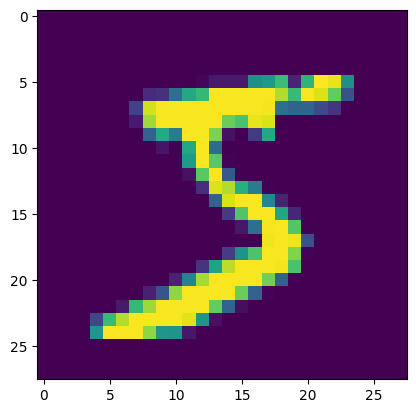

In [ ]:
plt.imshow(x_train_new[0])

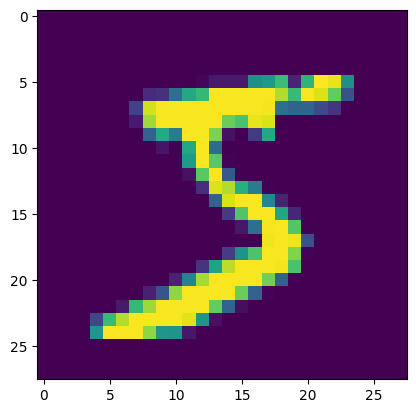

In [ ]:
plt.imshow(x_train[0])

In [ ]:
y_train_new = np_utils.to_categorical(y_train)

In [ ]:
x_test_new = np.array(list(map(adjust_data,x_test)))
y_test_new = np_utils.to_categorical(y_test)

## Using Tanh

In [ ]:
# Network
net = Network()
net.add(FlattenLayer())
net.add(FCLayer(100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
net.add(ActivationLayer(tanh, tanh_prime))

# train on 1000 samples
# as we didn't implemented mini-batch GD, training will be pretty slow if we update at each iteration on 60000 samples...
net.use(mse, mse_prime)
net.fit(x_train_new[0:1000], y_train_new[0:1000], epochs=30, learning_rate=0.1)

epoch 1: loss=0.061711071353514425
epoch 2: loss=0.04381579847927985
epoch 3: loss=0.037806125444039995
epoch 4: loss=0.03286413479661048
epoch 5: loss=0.028708143687248087
epoch 6: loss=0.025276277908129308
epoch 7: loss=0.02239604411824325
epoch 8: loss=0.019949261829668403
epoch 9: loss=0.017863682027516214
epoch 10: loss=0.016094338064557852
epoch 11: loss=0.014578204591808239
epoch 12: loss=0.01326690913048083
epoch 13: loss=0.012122842501952056
epoch 14: loss=0.011113819086035497
epoch 15: loss=0.010217106196341906
epoch 16: loss=0.009418689085140798
epoch 17: loss=0.008709037448366243
epoch 18: loss=0.008078424862249646
epoch 19: loss=0.007515125012091782
epoch 20: loss=0.0070081298226870176
epoch 21: loss=0.006549723109069022
epoch 22: loss=0.006135584436385249
epoch 23: loss=0.005762240373378424
epoch 24: loss=0.005425353170623614
epoch 25: loss=0.005120614467880427
epoch 26: loss=0.004844187837458064
epoch 27: loss=0.004592452504008178
epoch 28: loss=0.004361919226316902
epoc

In [ ]:
# test on 3 samples
print(np.array(x_test_new[0:3]).shape)
out = net.predict(x_test_new[0:3])
print("\n")
print("predicted values : ")
print(out, end="\n")
y_preds = np.array([])
for o in out:
  y_preds=np.append(y_preds,np.argmax(o,axis=1)[0])
print(y_preds)
print("true values : ")
print(np.argmax(y_test_new[0:3],axis=1))

(3, 28, 28)


predicted values : 
[array([[-0.03912213, -0.03921397, -0.1275229 , -0.04988349,  0.02810371,
         0.02196716,  0.00697523,  0.98598719, -0.0562818 , -0.01458953]]), array([[ 0.06723146, -0.20439004,  0.81081784, -0.01345271,  0.04599338,
         0.48863626,  0.66210484, -0.16233435, -0.33516962, -0.14491651]]), array([[-0.10529773,  0.9567271 , -0.10295946,  0.00530119, -0.07458343,
         0.01323701, -0.00869256,  0.04032832, -0.04482996, -0.04605788]])]
[7. 2. 1.]
true values : 
[7 2 1]


In [ ]:
net.summary()

,type,input_shape,output_shape,fc_layer_shape,kernels_shape,number_of_params
0,FlattenLayer,"(28, 28)","(1, 784)",None,None,0
1,FCLayer,"(1, 784)","(1, 100)","(784, 100)",None,78500
2,ActivationLayer,"(1, 100)","(1, 100)",None,None,0
3,FCLayer,"(1, 100)","(1, 50)","(100, 50)",None,5050
4,ActivationLayer,"(1, 50)","(1, 50)",None,None,0
5,FCLayer,"(1, 50)","(1, 10)","(50, 10)",None,510
6,ActivationLayer,"(1, 10)","(1, 10)",None,None,0
7,Total number of params,,,,,84060


## Using Relu

In [ ]:
net_mnist_relu = Network()
net_mnist_relu.add(FlattenLayer())
net_mnist_relu.add(FCLayer(100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net_mnist_relu.add(ActivationLayer(relu, relu_prime))
net_mnist_relu.add(FCLayer(50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net_mnist_relu.add(ActivationLayer(relu, relu_prime))
net_mnist_relu.add(FCLayer(10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
net_mnist_relu.add(ActivationLayer(relu, relu_prime))

# train on 1000 samples
# as we didn't implemented mini-batch GD, training will be pretty slow if we update at each iteration on 60000 samples...
net_mnist_relu.use(mse, mse_prime)
net_mnist_relu.fit(x_train_new[0:1000], y_train_new[0:1000], epochs=30, learning_rate=0.1)

epoch 1: loss=0.04801302508269435
epoch 2: loss=0.02368322614587318
epoch 3: loss=0.015982819933969716
epoch 4: loss=0.01134895506641824
epoch 5: loss=0.00856121702827222
epoch 6: loss=0.006948611347850992
epoch 7: loss=0.00554460024609669
epoch 8: loss=0.0046741085350418205
epoch 9: loss=0.004242484982817345
epoch 10: loss=0.003730447791998104
epoch 11: loss=0.0034411716489257064
epoch 12: loss=0.003212851504007189
epoch 13: loss=0.0030619364034130663
epoch 14: loss=0.0026625255337591994
epoch 15: loss=0.002446474542031647
epoch 16: loss=0.002331679841937945
epoch 17: loss=0.002254688402337383
epoch 18: loss=0.0021895937886488785
epoch 19: loss=0.0021455457761958164
epoch 20: loss=0.002110849040313238
epoch 21: loss=0.002081715943212309
epoch 22: loss=0.002058336392461797
epoch 23: loss=0.0020406249357028186
epoch 24: loss=0.0020264033601599487
epoch 25: loss=0.0020132083187211804
epoch 26: loss=0.002002776934821111
epoch 27: loss=0.0019925631815482566
epoch 28: loss=0.001984611037502

In [ ]:
# test on 3 samples
print(np.array(x_test_new[0:3]).shape)
out = net_mnist_relu.predict(x_test_new[0:3])
print("\n")
print("predicted values : ")
print(out, end="\n")
y_preds = np.array([])
for o in out:
  y_preds=np.append(y_preds,np.argmax(o[0]))
print(y_preds)
print("true values : ")
print(np.argmax(y_test_new[0:3],axis=1))

(3, 28, 28)


predicted values : 
[array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.04232456, 0.        , 0.        ]]), array([[0.        , 0.        , 0.01514186, 0.        , 0.        ,
        0.        , 0.05905187, 0.        , 0.        , 0.        ]]), array([[0.        , 1.09263934, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])]
[7. 6. 1.]
true values : 
[7 2 1]


In [ ]:
np.argmax(net_mnist_relu.predict([x_test_new[0]])[0])

7

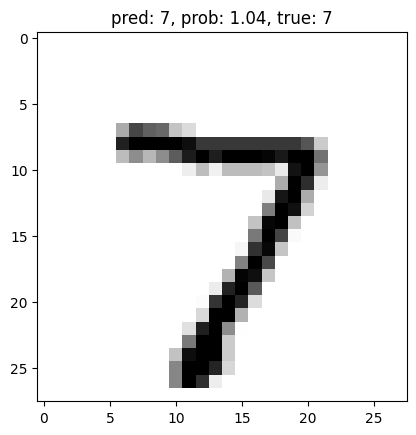

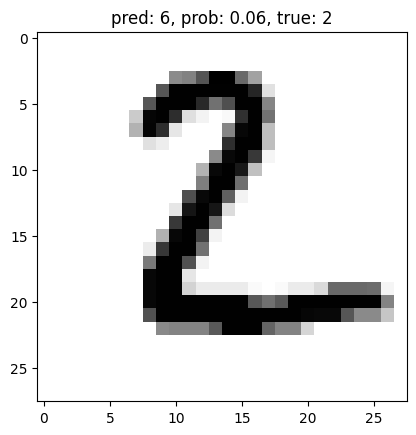

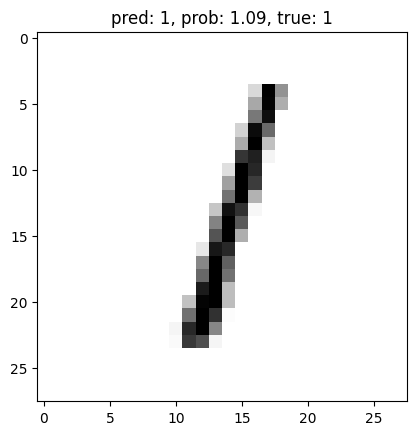

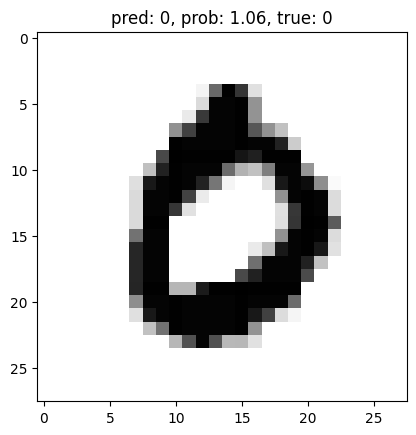

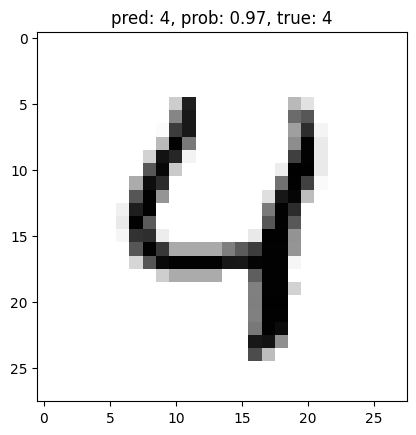

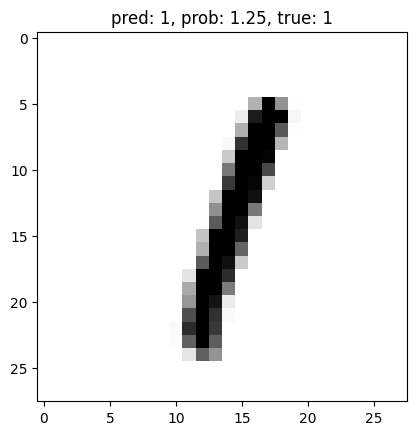

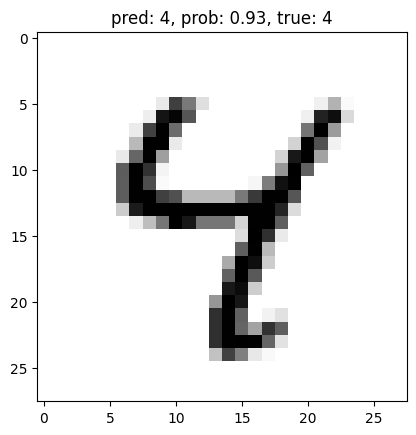

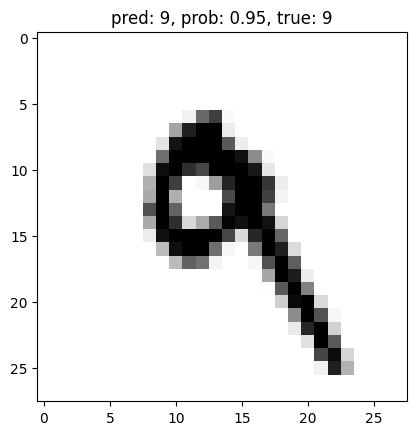

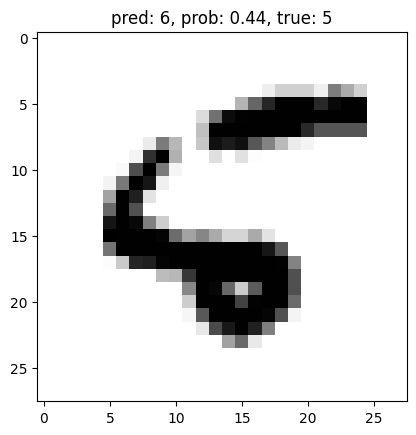

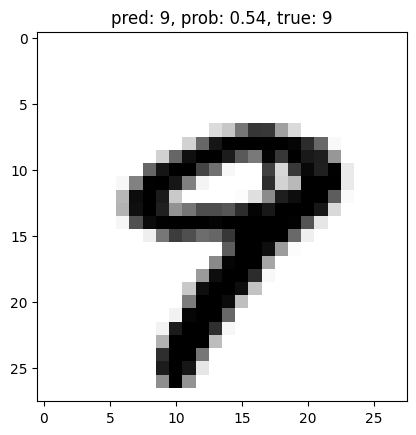

In [ ]:
visualize_test_samples(x_test_new,y_test_new,10,net_mnist_relu)

## Using Conv2D Layers

In [ ]:
x_train_new = adjust_data(x_train,True)
x_train_new.shape

(60000, 28, 28, 1)

In [ ]:
x_test_new = adjust_data(x_test,True)
x_test_new.shape

(10000, 28, 28, 1)

In [ ]:
# Network
net_conv = Network()
net_conv.add(Conv2D(3,5))
net_conv.add(FlattenLayer())
net_conv.add(FCLayer(100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net_conv.add(ActivationLayer(tanh, tanh_prime))
net_conv.add(FCLayer(50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net_conv.add(ActivationLayer(tanh, tanh_prime))
net_conv.add(FCLayer(10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
# net_conv.add(ActivationLayer(tanh, tanh_prime))
net_conv.add(SoftmaxLayer())

# train on 1000 samples
# as we didn't implemented mini-batch GD, training will be pretty slow if we update at each iteration on 60000 samples...
net_conv.use(mse, mse_prime)
net_conv.fit(x_train_new[0:1000], y_train_new[0:1000], epochs=20, learning_rate=0.1)

epoch 1: loss=0.0541530515437414
epoch 2: loss=0.03203132078874921
epoch 3: loss=0.02818379274971372
epoch 4: loss=0.02590123054516174
epoch 5: loss=0.029104286609050338
epoch 6: loss=0.02875781320126232
epoch 7: loss=0.030967908030519544
epoch 8: loss=0.03286022499973618
epoch 9: loss=0.03578771012603726
epoch 10: loss=0.036662310822619434
epoch 11: loss=0.03217958243049813
epoch 12: loss=0.032147186037235743
epoch 13: loss=0.03500976066106663
epoch 14: loss=0.03547711208686834
epoch 15: loss=0.03862087529276568
epoch 16: loss=0.035857904200850235
epoch 17: loss=0.0421177324805139
epoch 18: loss=0.039507136160294706
epoch 19: loss=0.035439297729493585
epoch 20: loss=0.03662253190497489


In [ ]:
net_conv.summary()

,type,input_shape,output_shape,fc_layer_shape,kernels_shape,number_of_params
0,Conv2D,"(28, 28, 1)","(26, 26, 5)",None,"(5, 3, 3, 1)",3425
1,FlattenLayer,"(26, 26, 5)","(1, 3380)",None,None,0
2,FCLayer,"(1, 3380)","(1, 100)","(3380, 100)",None,338100
3,ActivationLayer,"(1, 100)","(1, 100)",None,None,0
4,FCLayer,"(1, 100)","(1, 50)","(100, 50)",None,5050
5,ActivationLayer,"(1, 50)","(1, 50)",None,None,0
6,FCLayer,"(1, 50)","(1, 10)","(50, 10)",None,510
7,SoftmaxLayer,"(1, 10)","(1, 10)",None,None,0
8,Total number of params,,,,,347085


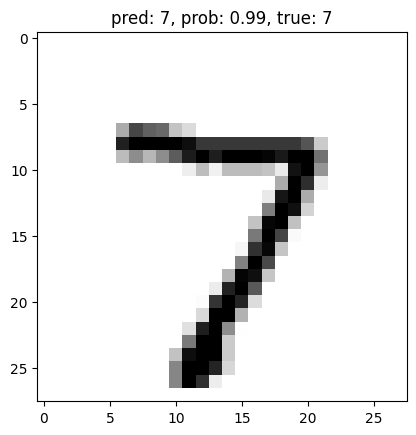

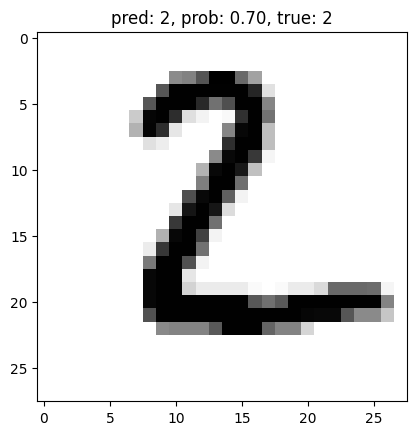

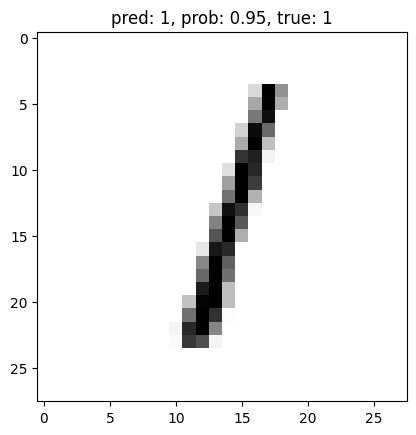

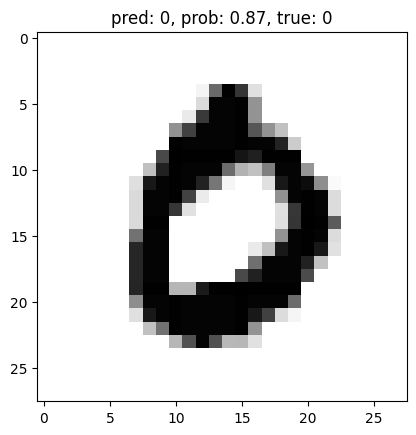

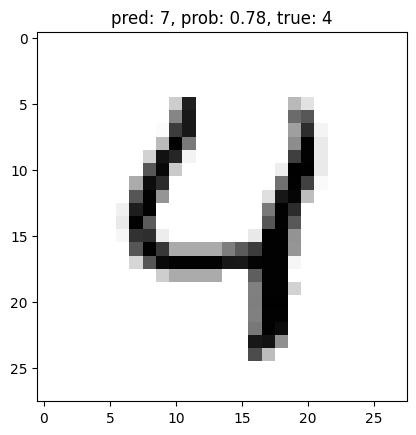

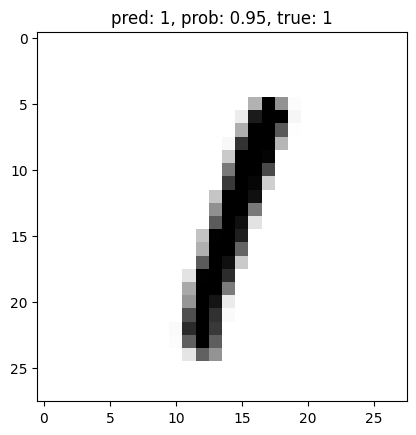

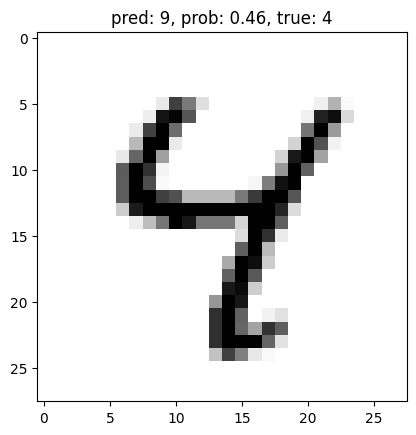

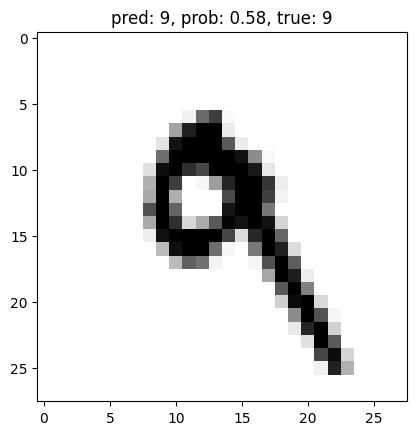

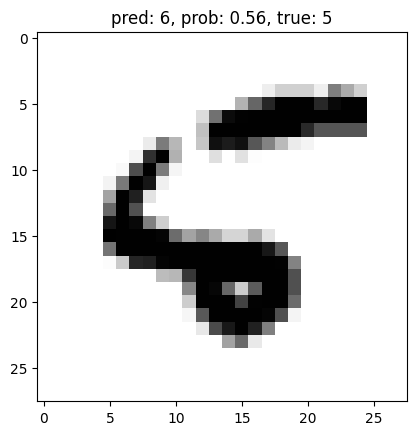

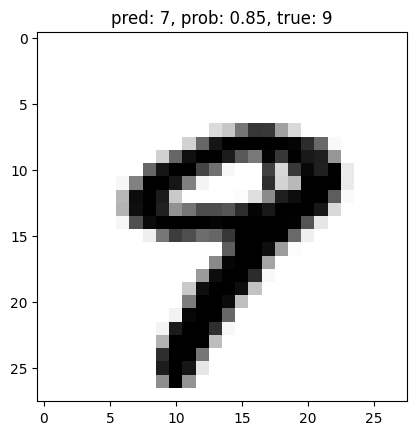

In [ ]:
visualize_test_samples(x_test_new,y_test_new,10,net_conv)

### Lets add more conv layers

In [ ]:
# Network
net_conv = Network()
net_conv.add(Conv2D(3,5))
net_conv.add(ActivationLayer(relu, relu_prime))
net_conv.add(Conv2D(3,2))
net_conv.add(ActivationLayer(relu, relu_prime))
net_conv.add(FlattenLayer())
net_conv.add(FCLayer(100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net_conv.add(ActivationLayer(tanh, tanh_prime))
net_conv.add(FCLayer(50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net_conv.add(ActivationLayer(tanh, tanh_prime))
net_conv.add(FCLayer(10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
# net_conv.add(ActivationLayer(tanh, tanh_prime))
net_conv.add(SoftmaxLayer())

# train on 1000 samples
# as we didn't implemented mini-batch GD, training will be pretty slow if we update at each iteration on 60000 samples...
net_conv.use(mse, mse_prime)
net_conv.fit(x_train_new[0:1000], y_train_new[0:1000], epochs=20, learning_rate=0.1)

epoch 1: loss=0.06252956418938718
epoch 2: loss=0.035190052647372655
epoch 3: loss=0.026144334456915014
epoch 4: loss=0.020199709993334414
epoch 5: loss=0.019848358606218044
epoch 6: loss=0.01869569821638013
epoch 7: loss=0.01608478596859721
epoch 8: loss=0.014166454393834219
epoch 9: loss=0.013553300511937295
epoch 10: loss=0.012592734327176051
epoch 11: loss=0.012690157281206161
epoch 12: loss=0.011437835035083773
epoch 13: loss=0.010368815953956714
epoch 14: loss=0.010514358473101778
epoch 15: loss=0.00938564225784264
epoch 16: loss=0.008516047398974474
epoch 17: loss=0.009195387158544595
epoch 18: loss=0.006024318753066152
epoch 19: loss=0.005603597618825383
epoch 20: loss=0.00530010044596539


In [ ]:
net_conv.summary()

,type,input_shape,output_shape,fc_layer_shape,kernels_shape,number_of_params
0,Conv2D,"(28, 28, 1)","(26, 26, 5)",None,"(5, 3, 3, 1)",3425
1,ActivationLayer,"(26, 26, 5)","(26, 26, 5)",None,None,0
2,Conv2D,"(26, 26, 5)","(24, 24, 2)",None,"(2, 3, 3, 5)",1242
3,ActivationLayer,"(24, 24, 2)","(24, 24, 2)",None,None,0
4,FlattenLayer,"(24, 24, 2)","(1, 1152)",None,None,0
5,FCLayer,"(1, 1152)","(1, 100)","(1152, 100)",None,115300
6,ActivationLayer,"(1, 100)","(1, 100)",None,None,0
7,FCLayer,"(1, 100)","(1, 50)","(100, 50)",None,5050
8,ActivationLayer,"(1, 50)","(1, 50)",None,None,0
9,FCLayer,"(1, 50)","(1, 10)","(50, 10)",None,510


## Using Pooling Layer

### Using Max Pooling

In [ ]:
# Network
net_conv_pool = Network()
net_conv_pool.add(Conv2D(3,5))
net_conv_pool.add(ActivationLayer(relu, relu_prime))
net_conv_pool.add(PoolingLayer(2,2,'max'))
net_conv_pool.add(Conv2D(3,2))
net_conv_pool.add(ActivationLayer(relu, relu_prime))
net_conv_pool.add(PoolingLayer(2,2,'max'))
net_conv_pool.add(FlattenLayer())
net_conv_pool.add(FCLayer(100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net_conv_pool.add(ActivationLayer(tanh, tanh_prime))
net_conv_pool.add(FCLayer(50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net_conv_pool.add(ActivationLayer(tanh, tanh_prime))
net_conv_pool.add(FCLayer(10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
# net_conv.add(ActivationLayer(tanh, tanh_prime))
net_conv_pool.add(SoftmaxLayer())

# train on 1000 samples
# as we didn't implemented mini-batch GD, training will be pretty slow if we update at each iteration on 60000 samples...
net_conv_pool.use(mse, mse_prime)
net_conv_pool.fit(x_train_new[0:1000], y_train_new[0:1000], epochs=10, learning_rate=0.1)

epoch 1: loss=0.08228739395268664
epoch 2: loss=0.05894426037629344
epoch 3: loss=0.039549664764555674
epoch 4: loss=0.03007094988879599
epoch 5: loss=0.02356719930185674
epoch 6: loss=0.020323648966302645
epoch 7: loss=0.017030746405372315
epoch 8: loss=0.01415685273102249
epoch 9: loss=0.011587143685047388
epoch 10: loss=0.0097212640736294


In [ ]:
net_conv_pool.summary()

,type,input_shape,output_shape,fc_layer_shape,kernels_shape,number_of_params
0,Conv2D,"(28, 28, 1)","(26, 26, 5)",None,"(5, 3, 3, 1)",3425
1,ActivationLayer,"(26, 26, 5)","(26, 26, 5)",None,None,0
2,PoolingLayer,"(26, 26, 5)","(13, 13, 5)",None,None,0
3,Conv2D,"(13, 13, 5)","(11, 11, 2)",None,"(2, 3, 3, 5)",332
4,ActivationLayer,"(11, 11, 2)","(11, 11, 2)",None,None,0
5,PoolingLayer,"(11, 11, 2)","(5, 5, 2)",None,None,0
6,FlattenLayer,"(5, 5, 2)","(1, 50)",None,None,0
7,FCLayer,"(1, 50)","(1, 100)","(50, 100)",None,5100
8,ActivationLayer,"(1, 100)","(1, 100)",None,None,0
9,FCLayer,"(1, 100)","(1, 50)","(100, 50)",None,5050


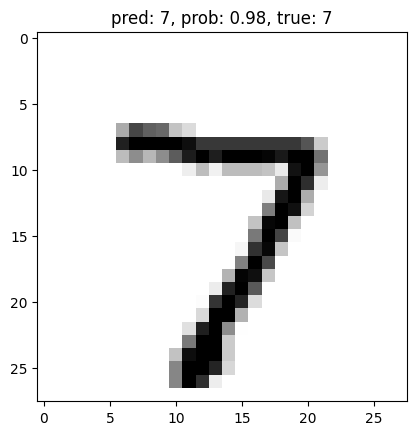

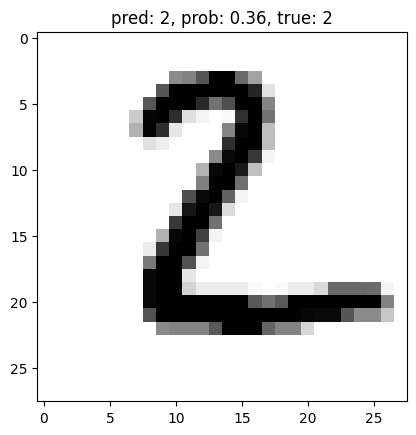

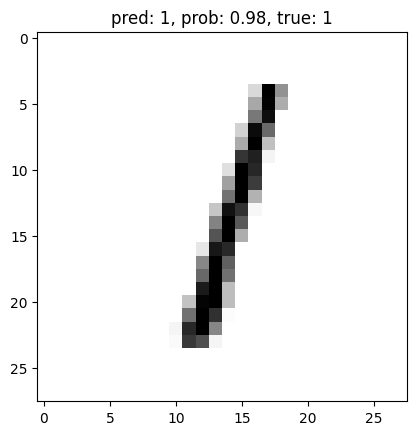

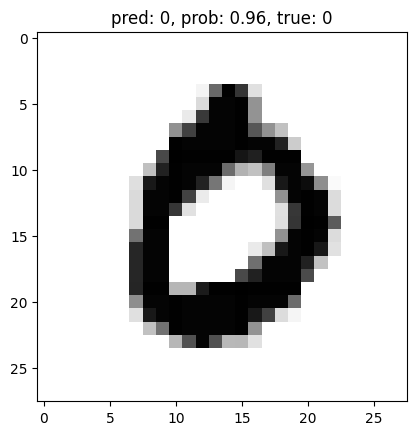

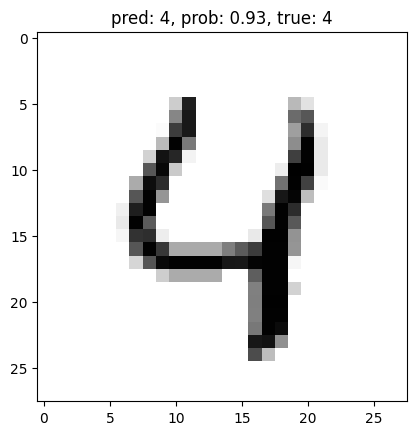

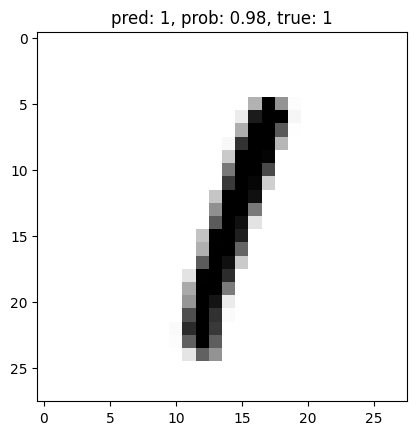

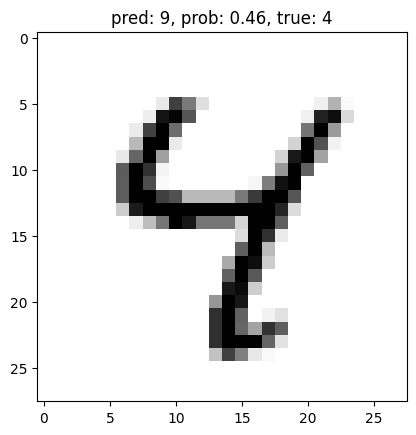

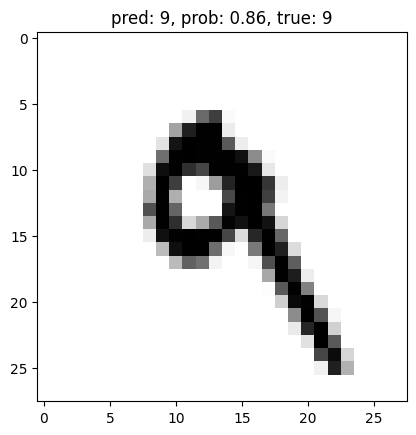

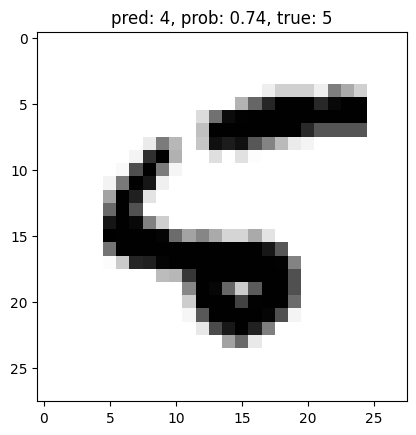

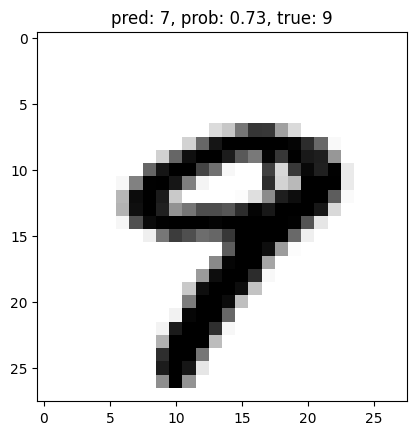

In [ ]:
visualize_test_samples(x_test_new,y_test_new,10,net_conv_pool)

### Using Avg Pooling

In [ ]:
# Network
net_conv_pool = Network()
net_conv_pool.add(Conv2D(3,5))
net_conv_pool.add(ActivationLayer(relu, relu_prime))
net_conv_pool.add(PoolingLayer(2,2,'avg'))
net_conv_pool.add(Conv2D(3,2))
net_conv_pool.add(ActivationLayer(relu, relu_prime))
net_conv_pool.add(PoolingLayer(2,2,'avg'))
net_conv_pool.add(FlattenLayer())
net_conv_pool.add(FCLayer(100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net_conv_pool.add(ActivationLayer(tanh, tanh_prime))
net_conv_pool.add(FCLayer(50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net_conv_pool.add(ActivationLayer(tanh, tanh_prime))
net_conv_pool.add(FCLayer(10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
# net_conv.add(ActivationLayer(tanh, tanh_prime))
net_conv_pool.add(SoftmaxLayer())

# train on 1000 samples
# as we didn't implemented mini-batch GD, training will be pretty slow if we update at each iteration on 60000 samples...
net_conv_pool.use(mse, mse_prime)
net_conv_pool.fit(x_train_new[0:1000], y_train_new[0:1000], epochs=10, learning_rate=0.1)

epoch 1: loss=0.06600355035377846
epoch 2: loss=0.03911713318574957
epoch 3: loss=0.029753850244152044
epoch 4: loss=0.024002862519933176
epoch 5: loss=0.02009131628862601
epoch 6: loss=0.017868242269183796
epoch 7: loss=0.015909141727071707
epoch 8: loss=0.013572443828888486
epoch 9: loss=0.011982274451351917
epoch 10: loss=0.011262769269804497


In [ ]:
net_conv_pool.summary()

,type,input_shape,output_shape,fc_layer_shape,kernels_shape,number_of_params
0,Conv2D,"(28, 28, 1)","(26, 26, 5)",None,"(5, 3, 3, 1)",3425
1,ActivationLayer,"(26, 26, 5)","(26, 26, 5)",None,None,0
2,PoolingLayer,"(26, 26, 5)","(13, 13, 5)",None,None,0
3,Conv2D,"(13, 13, 5)","(11, 11, 2)",None,"(2, 3, 3, 5)",332
4,ActivationLayer,"(11, 11, 2)","(11, 11, 2)",None,None,0
5,PoolingLayer,"(11, 11, 2)","(5, 5, 2)",None,None,0
6,FlattenLayer,"(5, 5, 2)","(1, 50)",None,None,0
7,FCLayer,"(1, 50)","(1, 100)","(50, 100)",None,5100
8,ActivationLayer,"(1, 100)","(1, 100)",None,None,0
9,FCLayer,"(1, 100)","(1, 50)","(100, 50)",None,5050


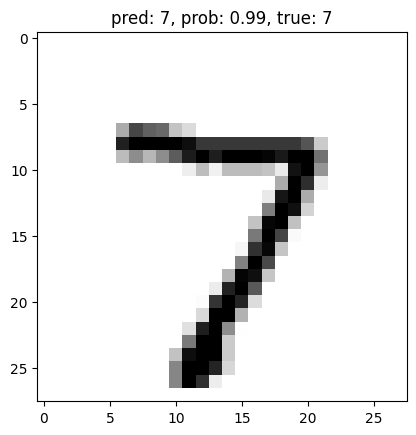

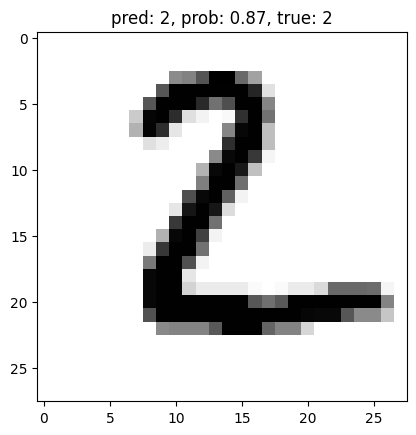

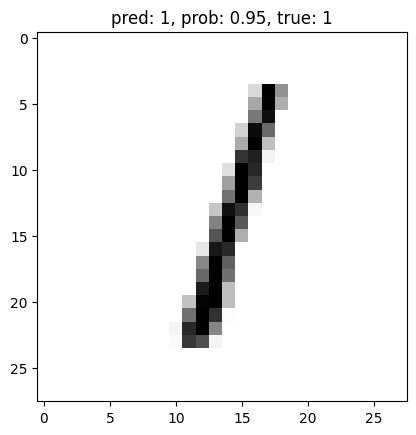

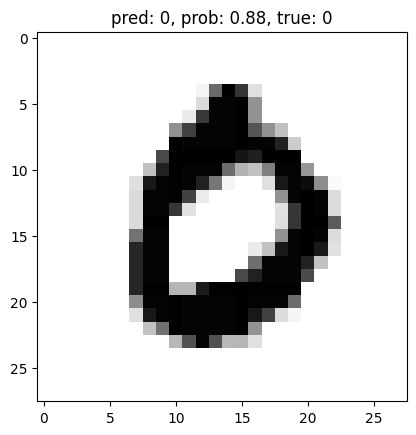

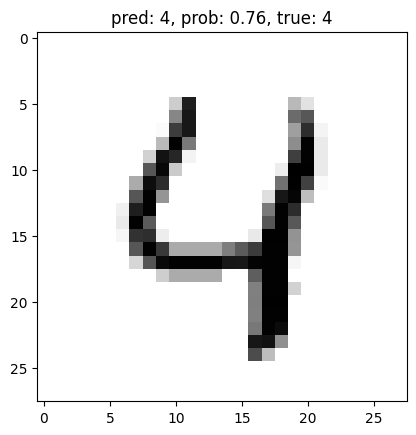

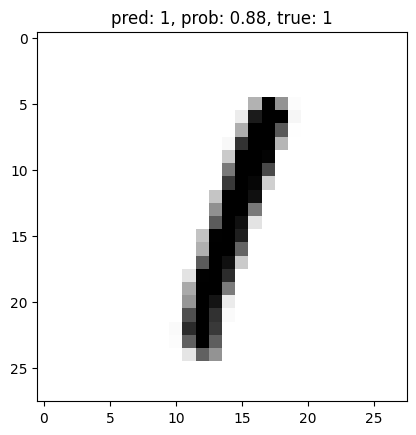

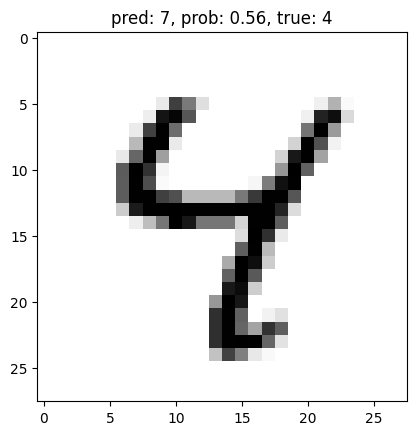

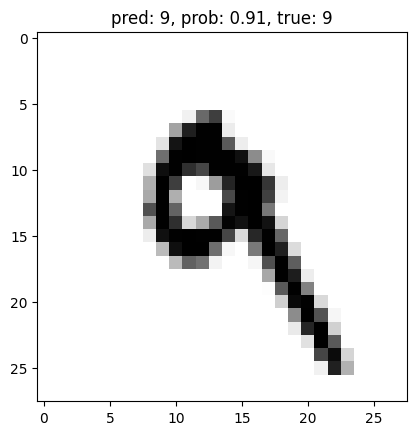

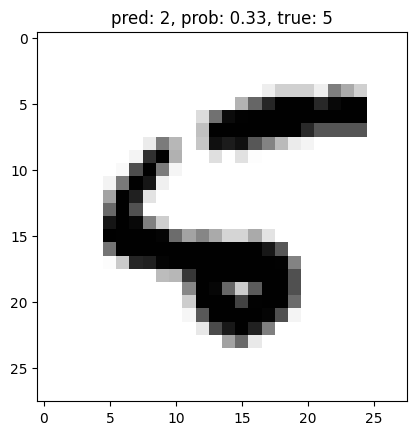

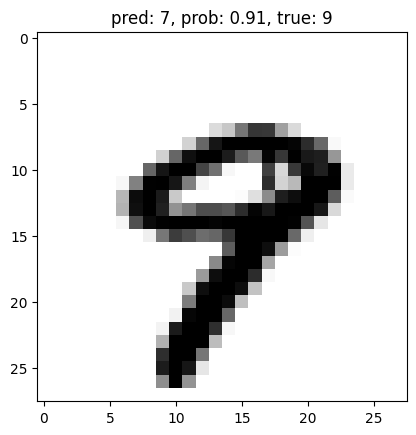

In [ ]:
visualize_test_samples(x_test_new,y_test_new,10,net_conv_pool)

### Using Global Average Pooling

In [ ]:
# Network
net_conv_pool = Network()
net_conv_pool.add(Conv2D(3,5))
net_conv_pool.add(ActivationLayer(relu, relu_prime))
net_conv_pool.add(PoolingLayer(3,1,'avg'))
net_conv_pool.add(Conv2D(3,2))
net_conv_pool.add(ActivationLayer(relu, relu_prime))
net_conv_pool.add(PoolingLayer(2,2,'max'))
net_conv_pool.add(GlobalAveragePoolingLayer())
net_conv_pool.add(FCLayer(100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net_conv_pool.add(ActivationLayer(tanh, tanh_prime))
net_conv_pool.add(FCLayer(50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net_conv_pool.add(ActivationLayer(tanh, tanh_prime))
net_conv_pool.add(FCLayer(10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
# net_conv.add(ActivationLayer(tanh, tanh_prime))
net_conv_pool.add(SoftmaxLayer())

# train on 1000 samples
# as we didn't implemented mini-batch GD, training will be pretty slow if we update at each iteration on 60000 samples...
net_conv_pool.use(mse, mse_prime)
net_conv_pool.fit(x_train_new[0:1000], y_train_new[0:1000], epochs=10, learning_rate=0.1)

epoch 1: loss=0.09032588739455864
epoch 2: loss=0.09023123589711776
epoch 3: loss=0.09013378086430461
epoch 4: loss=0.0899690417148009
epoch 5: loss=0.08960021204874877
epoch 6: loss=0.08854367750197256
epoch 7: loss=0.08625893840501907
epoch 8: loss=0.0844506574573819
epoch 9: loss=0.08359147988212154


In [ ]:
net_conv_pool.summary()

,type,input_shape,output_shape,fc_layer_shape,kernels_shape,number_of_params
0,Conv2D,"(28, 28, 1)","(26, 26, 5)",None,"(5, 3, 3, 1)",3425
1,ActivationLayer,"(26, 26, 5)","(26, 26, 5)",None,None,0
2,PoolingLayer,"(26, 26, 5)","(24, 24, 5)",None,None,0
3,Conv2D,"(24, 24, 5)","(22, 22, 2)",None,"(2, 3, 3, 5)",1058
4,ActivationLayer,"(22, 22, 2)","(22, 22, 2)",None,None,0
5,PoolingLayer,"(22, 22, 2)","(11, 11, 2)",None,None,0
6,GlobalAveragePoolingLayer,"(11, 11, 2)","(1, 2)",None,None,0
7,FCLayer,"(1, 2)","(1, 100)","(2, 100)",None,300
8,ActivationLayer,"(1, 100)","(1, 100)",None,None,0
9,FCLayer,"(1, 100)","(1, 50)","(100, 50)",None,5050


## Use Categorical crossentropy

In [316]:
# Network
net_conv_pool = Network()
net_conv_pool.add(Conv2D(3,5))
net_conv_pool.add(ActivationLayer(relu, relu_prime))
net_conv_pool.add(PoolingLayer(3,1,'avg'))
net_conv_pool.add(Conv2D(3,2))
net_conv_pool.add(ActivationLayer(relu, relu_prime))
net_conv_pool.add(PoolingLayer(2,2,'max'))
net_conv_pool.add(GlobalAveragePoolingLayer())
net_conv_pool.add(FCLayer(100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net_conv_pool.add(ActivationLayer(tanh, tanh_prime))
net_conv_pool.add(FCLayer(50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net_conv_pool.add(ActivationLayer(tanh, tanh_prime))
net_conv_pool.add(FCLayer(10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
# net_conv.add(ActivationLayer(tanh, tanh_prime))
net_conv_pool.add(SoftmaxLayer())

# train on 1000 samples
# as we didn't implemented mini-batch GD, training will be pretty slow if we update at each iteration on 60000 samples...
net_conv_pool.use(categorical_crossentropy, categorical_crossentropy_prime)
net_conv_pool.fit(x_train_new[0:1000], y_train_new[0:1000], epochs=10, learning_rate=0.1)

epoch 1: loss=2.353213646478093
epoch 2: loss=2.320423935506091
epoch 3: loss=2.132345163004053
epoch 4: loss=1.9983713496889808
epoch 5: loss=1.9229017694005057
epoch 6: loss=1.7364444335533677
epoch 7: loss=1.575320872789466
epoch 8: loss=1.4907215322724292
epoch 9: loss=1.4773709759318407
epoch 10: loss=1.476396096641313


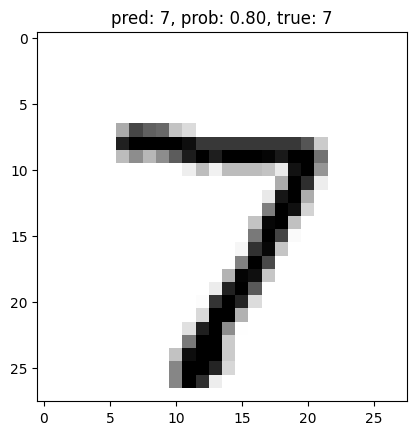

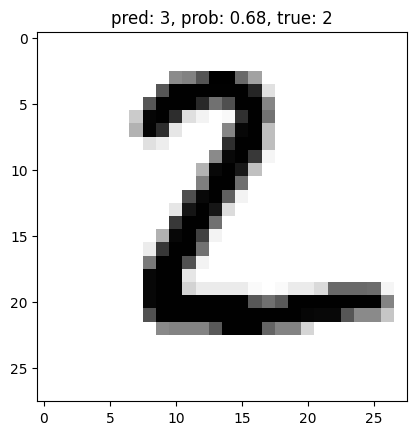

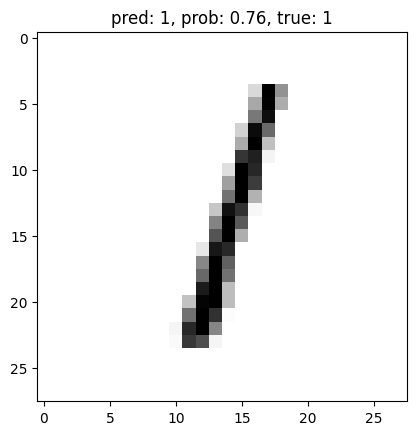

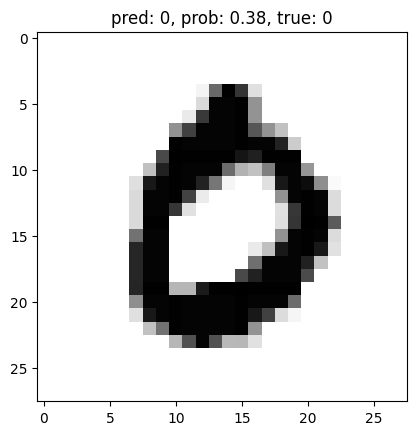

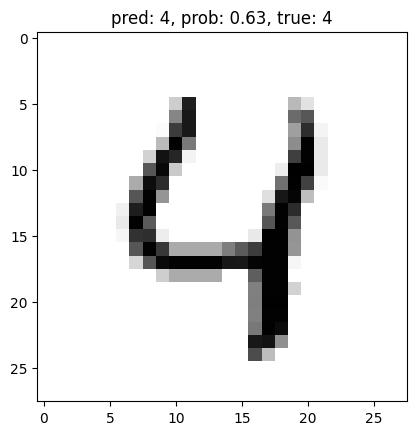

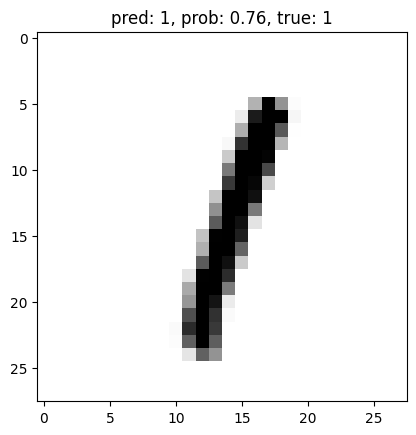

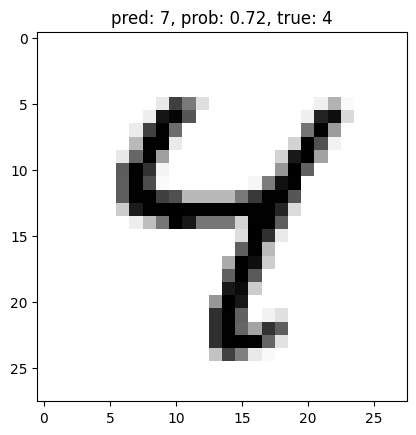

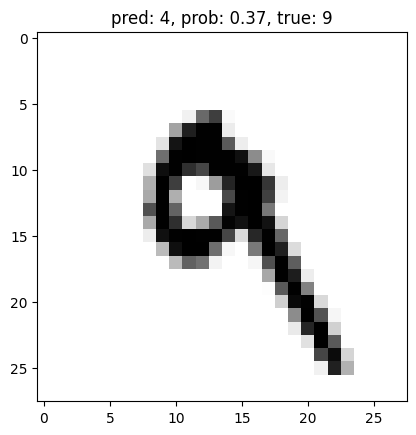

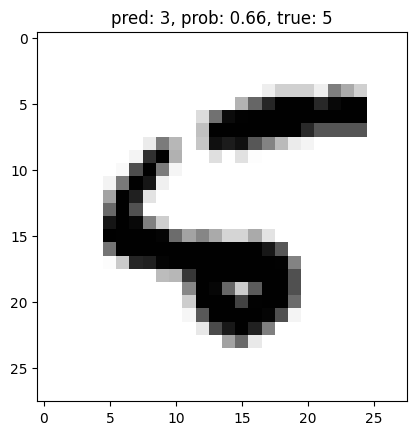

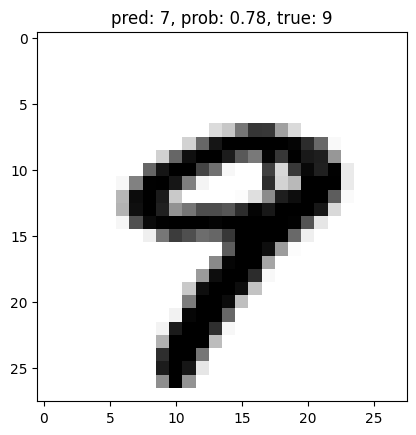

In [317]:
visualize_test_samples(x_test_new,y_test_new,10,net_conv_pool)

## Use Dropout Layer

In [318]:
# Network
net_conv_pool = Network()
net_conv_pool.add(Conv2D(3,5))
net_conv_pool.add(ActivationLayer(relu, relu_prime))
net_conv_pool.add(PoolingLayer(3,1,'avg'))
net_conv_pool.add(Conv2D(3,2))
net_conv_pool.add(ActivationLayer(relu, relu_prime))
net_conv_pool.add(PoolingLayer(2,2,'max'))
net_conv_pool.add(GlobalAveragePoolingLayer())
net_conv_pool.add(FCLayer(100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net_conv_pool.add(ActivationLayer(tanh, tanh_prime))
net_conv_pool.add(DropoutLayer(drop_rate=0.2))
net_conv_pool.add(FCLayer(50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net_conv_pool.add(ActivationLayer(tanh, tanh_prime))
net_conv_pool.add(FCLayer(10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
# net_conv.add(ActivationLayer(tanh, tanh_prime))
net_conv_pool.add(SoftmaxLayer())

# train on 1000 samples
# as we didn't implemented mini-batch GD, training will be pretty slow if we update at each iteration on 60000 samples...
net_conv_pool.use(categorical_crossentropy, categorical_crossentropy_prime)
net_conv_pool.fit(x_train_new[0:1000], y_train_new[0:1000], epochs=10, learning_rate=0.1)

epoch 1: loss=2.3626977811293197
epoch 2: loss=2.340056757118249
epoch 3: loss=2.3367972484978004
epoch 4: loss=2.330171108477414
epoch 5: loss=2.274459583580519
epoch 6: loss=2.1600642834956134
epoch 7: loss=2.0449156344901405
epoch 8: loss=1.9861872276335306
epoch 9: loss=1.9584731398022523
epoch 10: loss=1.9394634201773435


In [319]:
net_conv_pool.summary()

,type,input_shape,output_shape,fc_layer_shape,kernels_shape,number_of_params
0,Conv2D,"(28, 28, 1)","(26, 26, 5)",None,"(5, 3, 3, 1)",3425
1,ActivationLayer,"(26, 26, 5)","(26, 26, 5)",None,None,0
2,PoolingLayer,"(26, 26, 5)","(24, 24, 5)",None,None,0
3,Conv2D,"(24, 24, 5)","(22, 22, 2)",None,"(2, 3, 3, 5)",1058
4,ActivationLayer,"(22, 22, 2)","(22, 22, 2)",None,None,0
5,PoolingLayer,"(22, 22, 2)","(11, 11, 2)",None,None,0
6,GlobalAveragePoolingLayer,"(11, 11, 2)","(1, 2)",None,None,0
7,FCLayer,"(1, 2)","(1, 100)","(2, 100)",None,300
8,ActivationLayer,"(1, 100)","(1, 100)",None,None,0
9,DropoutLayer,"(1, 100)","(1, 100)",None,None,0
